## Regression
In machine learning, regression is an approach to find the relationship between a set of variables. This is used to predict the outcome of an event based on the relationship between variables obtained from the dataset.

(Inspired by a tutorial published at www.pythonprogramming.net)



In [14]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm, metrics

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

style.use('ggplot')

# Key to access Quandl DB
quandl_api_key = open('data/quandl_api_key.txt', 'r').read()
quandl_api_key

'eon-D6FSnS7fa9m8xm34'

In [2]:
# Download the dataset and set the the columns
df = quandl.get("WIKI/GOOGL")
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [3]:
# We want to predict the close price of this stock. 
# To do this, we're going to consider the following features:
# - Close price
# - Volume
# - Volatility (percentual change considering the highest/lowest prices)
# - Daily change (percentual change considering the open/close prices)

# Creating new columns to represent volatility (high - low) and daily percent change 
df['Volatility']   = (df['Adj. High'] - df['Adj. Low'])   / df['Adj. Close'] * 100.0
df['Daily Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open']  * 100.0
df = df[['Adj. Close', 'Volatility', 'Daily Change', 'Adj. Volume']]

df.head()

,Adj. Close,Volatility,Daily Change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0


In [4]:
# Creating a new column to carry the predicted price (label). 
# This column is configured to carry the close price 
# of 20 (working!) days in the future (1 month)
NUMBER_OF_DAYS_TO_PREDICT = 20
df['n_days_ahead'] = df['Adj. Close'].shift(-NUMBER_OF_DAYS_TO_PREDICT)

df.tail(25)

,Adj. Close,Volatility,Daily Change,Adj. Volume,n_days_ahead
Date,,,,,
2018-02-21,1113.75,2.575982,0.419259,2024534.0,1094.00
2018-02-22,1109.90,1.829895,-0.828292,1386115.0,1053.15
2018-02-23,1128.09,1.822550,0.842973,1234539.0,1026.55
2018-02-26,1143.70,1.299292,1.046066,1489118.0,1054.09
2018-02-27,1117.51,2.457249,-2.289936,2094863.0,1006.94
2018-02-28,1103.92,2.232952,-1.611408,2431023.0,NaN
2018-03-01,1071.41,4.104871,-3.436559,2766856.0,NaN
2018-03-02,1084.14,3.392551,2.472637,2508145.0,NaN
2018-03-05,1094.76,2.640761,1.542486,1432369.0,NaN


In [5]:
# Load features into numpy arrays (X matrix)
# Get all columns except for predict_label
X = np.array(df.drop(['n_days_ahead'], 1)) 
# Preprocessing features to scale values (range between -1 and +1) and potentially 
# speed up model building
X = preprocessing.scale(X)

X = X[:-NUMBER_OF_DAYS_TO_PREDICT]              # values to train
X_to_forecast = X[-NUMBER_OF_DAYS_TO_PREDICT:]  # values used to predict !


# Load labels into a numpy array also (y vector) 
#    and remove the NaN in the end (the values we're going to predict soon)
y = np.array(df['n_days_ahead'])          
y = y[:-NUMBER_OF_DAYS_TO_PREDICT]
# Split data into training and validation data, for both predictors and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# call this method
# Creating training/testing sets (80/20)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)

print("train_size={} test_size={}".format(len(X_train), len(X_test)))

train_size=2723 test_size=681


In [6]:
# First let's try some different kernels of Support Vector Regression (SVR) classifier
for k in ['linear','poly','rbf','sigmoid']:
    classifier = svm.SVR(kernel=k)
    classifier.fit(X_train, y_train)
    accuracy = classifier.score(X_test, y_test)
    print(k,accuracy)

linear 0.987190247514
poly 0.694188393048
rbf 0.769218157309
sigmoid 0.899106390822


In [16]:
# Now training a simple linear regression classifier
classifier = LinearRegression()
classifier.fit(X_train, y_train)

# Checking the confidence of the model we just trained
print("Accuracy = {0:.2f}%".format(classifier.score(X_test, y_test)*100))
print("MEA = {0:.4f}".format(metrics.mean_absolute_error(y_test, classifier.predict(X_test))))

Accuracy = 98.79%
MEA = 21.6877


In [8]:
# Now predicting values for X_to_forecast
predictions = classifier.predict(X_to_forecast)
print(predictions)

# Filling predictions in new rows 
# We're creating a new column to put the predicted Adj. Close prices :)
df['Predicted Adj. Close'] = np.nan

# Get the last datetime index in the DataFrame
ONE_DAY_IN_SECONDS = 86400
last_datetime_timestamp = df.iloc[-1].name.timestamp()

for i in predictions:
    # create new date index and fill columns
    # XXX: not considering weekends!
    last_datetime_timestamp += ONE_DAY_IN_SECONDS
    new_index = datetime.datetime.fromtimestamp(last_datetime_timestamp)
    df.loc[new_index] = [np.nan for _ in range(len(df.columns)-1)] + [i] # hack to fill columns ('i' is the last)

df.tail(40)

[ 1188.25629723  1193.12777574  1191.94140029  1128.56056107  1076.23022307
  1091.23994069  1064.72151488  1012.98272369  1050.29577881  1064.28764235
  1064.46087159  1082.14182339  1100.98149668  1105.77501022  1113.31781835
  1123.35400381  1120.27332797  1138.39055959  1154.321497    1127.47658641]


,Adj. Close,Volatility,Daily Change,Adj. Volume,n_days_ahead,Predicted Adj. Close
Date,,,,,,
2018-02-28,1103.92,2.232952,-1.611408,2431023.0,NaN,NaN
2018-03-01,1071.41,4.104871,-3.436559,2766856.0,NaN,NaN
2018-03-02,1084.14,3.392551,2.472637,2508145.0,NaN,NaN
2018-03-05,1094.76,2.640761,1.542486,1432369.0,NaN,NaN
2018-03-06,1100.90,1.010991,-0.108883,1169068.0,NaN,NaN
2018-03-07,1115.04,2.357763,2.033272,1537429.0,NaN,NaN
2018-03-08,1129.38,1.260869,1.090226,1510478.0,NaN,NaN
2018-03-09,1160.84,2.300920,1.872751,2070174.0,NaN,NaN
2018-03-12,1165.93,1.626170,0.075533,2129297.0,NaN,NaN


In [9]:
df.tail(50)

,Adj. Close,Volatility,Daily Change,Adj. Volume,n_days_ahead,Predicted Adj. Close
Date,,,,,,
2018-02-13,1054.14,1.356556,0.394286,1574121.0,1148.89,NaN
2018-02-14,1072.70,2.393027,1.743304,2029979.0,1150.61,NaN
2018-02-15,1091.36,2.462066,0.730075,1806206.0,1134.42,NaN
2018-02-16,1095.50,1.529895,0.193894,1971928.0,1100.07,NaN
2018-02-20,1103.59,2.382225,0.991068,1646405.0,1095.80,NaN
2018-02-21,1113.75,2.575982,0.419259,2024534.0,1094.00,NaN
2018-02-22,1109.90,1.829895,-0.828292,1386115.0,1053.15,NaN
2018-02-23,1128.09,1.822550,0.842973,1234539.0,1026.55,NaN
2018-02-26,1143.70,1.299292,1.046066,1489118.0,1054.09,NaN


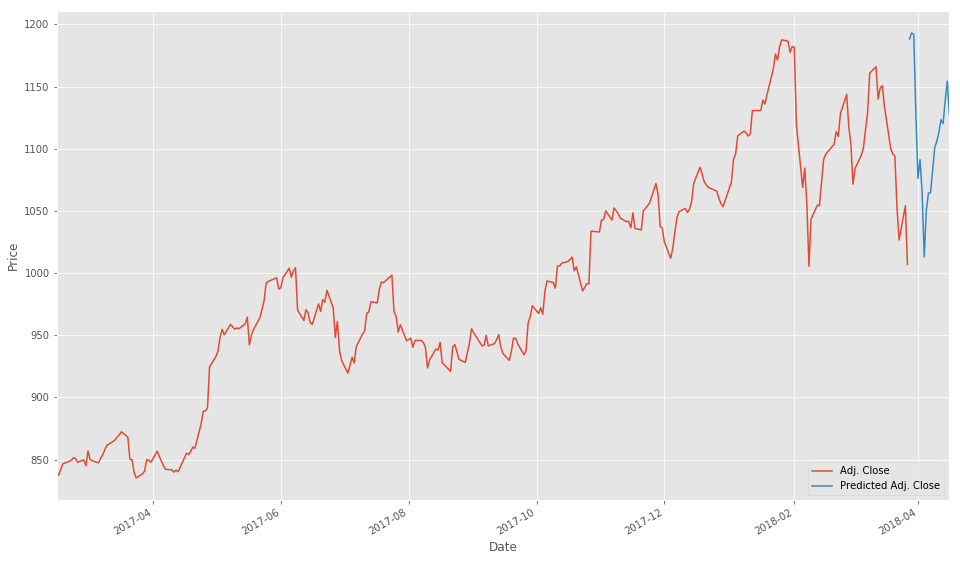

In [10]:
# Now plot a graph of the Adj. Close prices and the forecast prices of approximately the last year
#    we just predicted using the Linear Regression classifier
plt.clf()

fig = plt.figure(figsize=(16,10))
df[-300:]['Adj. Close'].plot()
df[-300:]['Predicted Adj. Close'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()